## Using Laplace Torch library to implement laplace approximation for bayesian linear regression

In [1]:
import torch
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import numpy as np
from laplace.baselaplace import FullLaplace, BaseLaplace
from laplace.curvature.backpack import BackPackGGN
from laplace import Laplace, marglik_training


In [2]:
def get_sinusoid_example(n_data=150, sigma_noise=0.3, batch_size=150):
    # create simple sinusoid data set
    X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
    y_train = torch.sin(X_train) + torch.randn_like(X_train) * sigma_noise
    train_loader = data_utils.DataLoader(
        data_utils.TensorDataset(X_train, y_train), 
        batch_size=batch_size
    )
    X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
    return X_train, y_train, train_loader, X_test

In [3]:
def get_linear_example(n_data=150, sigma_noise=0.3, batch_size=150):
    # create simple linear data set
    X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
    y_train = 3*X_train + 2 + torch.randn_like(X_train) * sigma_noise
    train_loader = data_utils.DataLoader(
        data_utils.TensorDataset(X_train, y_train), 
        batch_size=batch_size
    )
    X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
    return X_train, y_train, train_loader, X_test

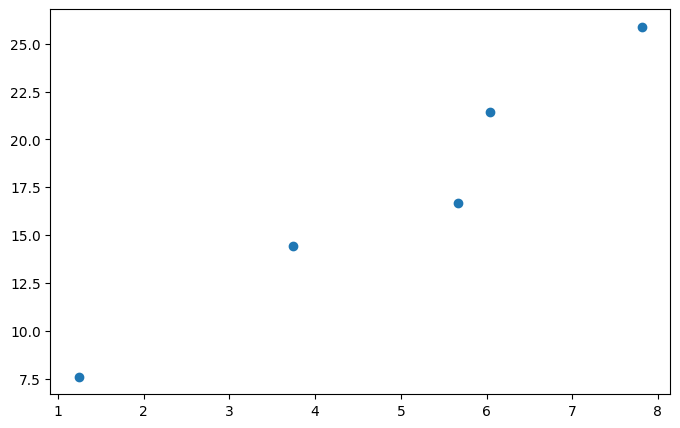

In [101]:
# Plot the data

X_train, y_train, train_loader, X_test = get_linear_example(n_data=5, sigma_noise=2, batch_size=5)

def plot_data(X_train, y_train, X_test=None, y_test=None, samples=None):
    plt.figure(figsize=(8, 5))
    plt.scatter(X_train.numpy(), y_train.numpy())
    if X_test is not None:
        plt.plot(X_test.numpy(), y_test.numpy(), color='k')
    if samples is not None:
        plt.plot(X_test.numpy(), samples.numpy(), color='r', alpha=0.2)
    plt.show()

plot_data(X_train, y_train)



#### Prior

In [102]:
prior_mean_1 = -3
prior_std_1 = 1
prior_mean_0 = 2
prior_std_0 = 1

prior_dist_1 = torch.distributions.Normal(prior_mean_1, prior_std_1)
prior_dist_0 = torch.distributions.Normal(prior_mean_0, prior_std_0)

In [103]:
# define a simple linear regression model with the name LinearRegressionModel

class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(1, 1)
        
    def forward(self, x):
        return self.linear(x)
    
    def log_likelihood(self, x, y):
        y_pred = self.forward(x).squeeze(-1)
        return torch.distributions.Normal(y_pred, 0.3).log_prob(y).sum()
    
    def log_prior(self):
        return prior_dist_1.log_prob(self.linear.weight).sum() + prior_dist_0.log_prob(self.linear.bias).sum()
    
    def log_posterior(self, x, y):
        return self.log_likelihood(x, y) + self.log_prior()
    

In [104]:
model = LinearRegressionModel()
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0.5710]], requires_grad=True)
Parameter containing:
tensor([-0.3620], requires_grad=True)


#### Theta MAP

In [105]:
n_epochs = 1000

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = -model.log_posterior(X,y)
        loss.backward()
        optimizer.step()


In [106]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[2.1583]], requires_grad=True)
Parameter containing:
tensor([4.6561], requires_grad=True)


In [107]:
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)

# take prior as a standard normal distribution
# log_prior = torch.zeros(la.n_params, requires_grad=True)
# log_sigma = torch.tensor(0.5 * torch.ones(1, requires_grad=True), requires_grad=True)
log_prior, log_sigma = torch.ones(2, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [108]:
log_prior, log_sigma

(tensor([-1.6020, -3.4035], requires_grad=True),
 tensor([1.1885], requires_grad=True))

In [109]:
def plot_regression(X_train, y_train, X_test, f_test, y_std, plot=True, 
                    file_name='regression_example'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True,
                                figsize=(8, 4))
    ax1.set_title('MAP')
    ax1.scatter(X_train.flatten(), y_train.flatten(), alpha=0.3, color='tab:orange')
    ax1.plot(X_test, f_test, color='black', label='$f_{MAP}$')
    ax1.legend()

    ax2.set_title('LA')
    ax2.scatter(X_train.flatten(), y_train.flatten(), alpha=0.3, color='tab:orange')
    ax2.plot(X_test, f_test, label='$\mathbb{E}[f]$')
    ax2.fill_between(X_test, f_test-y_std*2, f_test+y_std*2, 
                     alpha=0.3, color='tab:blue', label='$2\sqrt{\mathbb{V}\,[y]}$')
    ax2.legend()
    # ax1.set_ylim([0, 30])
    ax1.set_xlim([X_test.min(), X_test.max()])
    ax2.set_xlim([X_test.min(), X_test.max()])
    ax1.set_ylabel('$y$')
    ax1.set_xlabel('$x$')
    ax2.set_xlabel('$x$')
    plt.tight_layout()
    if plot:
        plt.show()

#### Laplace Approximation for Posterior

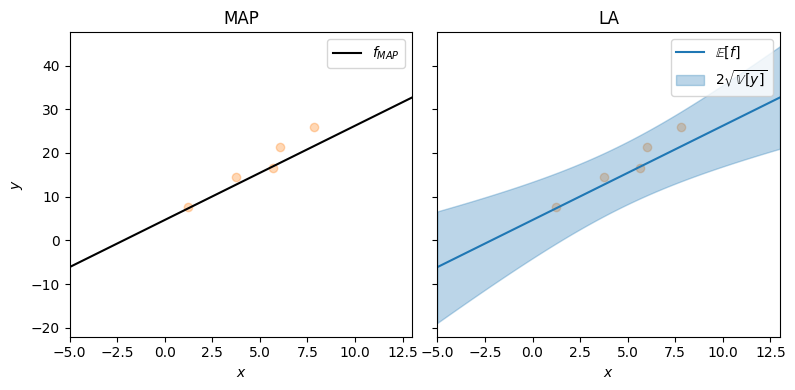

In [110]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std)

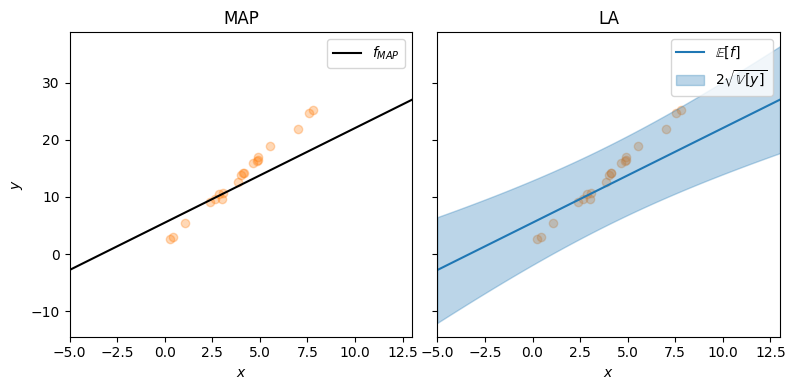

In [60]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std)

#### Laplace Approximation for Likelihood

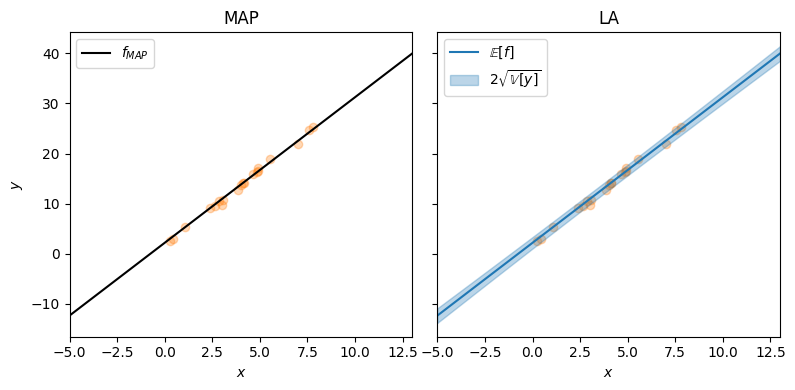

In [19]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std)

## Using BaseLaplace -> not implemented only

## Using FullLaplace -> don't know what is teh difference

In [111]:
full_la = FullLaplace(model, 'regression', sigma_noise=0.3, prior_mean=0, prior_precision=0.5)
full_la.fit(train_loader)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.LinearRegressionModel'> although the module has parameters
  warnings.warn(


In [ ]:
log_prior, log_sigma = torch.ones(2, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()